### 1. Imports

In [1]:
from pathlib import Path
import json, numpy as np, matplotlib.pyplot as plt

from utils.config import PART_COLORS
from utils.mask_utils import load_mask
from utils.voxel_utils import get_voxel_points_by_parts
from utils.camera_geometry import project
from utils.projection_utils import visualize_reprojection, project_colored_voxels
from utils.visualization import plot_voxel
from utils.camera_estimation import *

### 2. Load data

Voxel grid: (128, 79, 128, 3) | Front mask: (79, 128, 3) | Drone mask: (337, 491, 3)


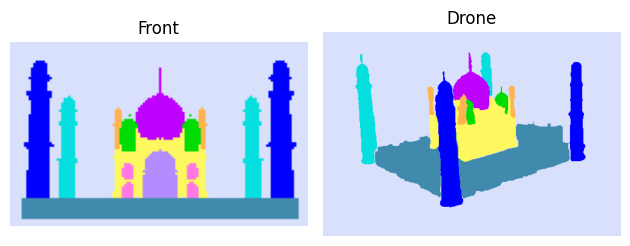

In [2]:
root = Path.cwd()
data = root / "data"
monuments = ["Akbar","Bibi","Charminar","Itimad","Taj"]
monument = monuments[1] #choose any other
voxel_grid = np.load(root/"results_temp/1.Orthographic_Voxel_Carving"/f"{monument}_voxel_grid.npz")["voxel_grid"]
max_dim = np.max(voxel_grid.shape)

front_mask = load_mask(data, monument, "front", max_dim)
drone_mask = load_mask(data, monument, "drone")
print("Voxel grid:", voxel_grid.shape,
      "| Front mask:", front_mask.shape,
      "| Drone mask:", drone_mask.shape)
for i,(t,m) in enumerate([("Front",front_mask),("Drone",drone_mask)]):
    plt.subplot(1,2,i+1); plt.imshow(m); plt.title(t); plt.axis("off")
plt.tight_layout(); plt.show()


### 3. Initialize camera


📐 front
Estimated scale factor: 1.7595
Adjusted focal length: 259.38


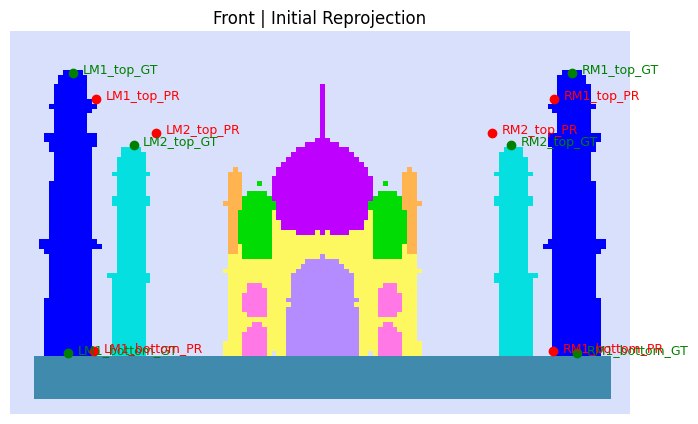


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM1_bottom | (116.5, 66.0)                  | (111.69, 65.49)                | 4.84
RM1_top | (115.5, 8.0)                   | (111.77, 13.49)                | 6.63
LM1_bottom | (11.5, 66.0)                   | (16.84, 65.49)                 | 5.37
LM1_top | (12.5, 8.0)                    | (17.18, 13.53)                 | 7.24
LM2_top | (25.0, 23.0)                   | (29.62, 20.47)                 | 5.26
RM2_top | (103.0, 23.0)                  | (99.05, 20.47)                 | 4.69

Average Reprojection Error: 5.67 pixels

📐 drone
Estimated scale factor: 1.4510
Adjusted focal length: 912.48


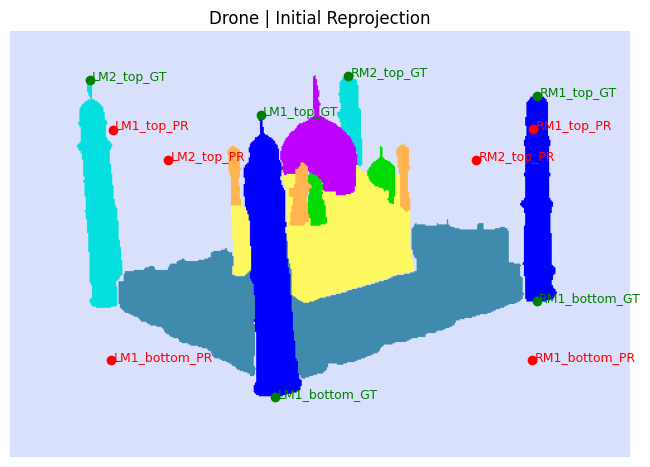


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM1_bottom | (416.5, 213.0)                 | (413.26, 259.93)               | 47.05
RM1_top | (417.0, 51.0)                  | (413.54, 76.99)                | 26.21
LM1_bottom | (209.5, 289.0)                 | (79.61, 259.93)                | 133.10
LM1_top | (198.0, 66.0)                  | (80.78, 77.15)                 | 117.75
LM2_top | (62.5, 38.0)                   | (124.54, 101.56)               | 88.82
RM2_top | (267.5, 35.0)                  | (368.81, 101.56)               | 121.22

Average Reprojection Error: 89.03 pixels


In [3]:
# ---------- INITIAL CAMERA PARAMS (ALL VIEWS) ----------

views = {
    "front":  front_mask,
    "drone":  drone_mask,
}

parts_for_alignment = ["front_minarets", "back_minarets"]
minaret_colors = [PART_COLORS["front_minarets"], PART_COLORS["back_minarets"]]

init_camera_params, init_keypoints = {}, {}

for view, mask_img in views.items():
    print(f"\n📐 {view}")

    try:
        voxel_kps, image_kps = extract_minaret_kps_for_view(
            voxel_grid, mask_img, minaret_colors
        )

        init_params = auto_compute_initial_params_matching_bbox(
            voxel_grid,
            mask_img,
            PART_COLORS,
            parts_for_alignment=parts_for_alignment,
            fov_deg=30,
        )

        visualize_reprojection(
            mask_img,
            voxel_kps,
            image_kps,
            init_params,
            title=f"{view.capitalize()} | Initial Reprojection",
        )

        init_camera_params[view] = init_params
        init_keypoints[view] = {
            "voxel": voxel_kps,
            "image": image_kps,
            "mask":  mask_img,
        }

    except Exception as e:
        print(f"⚠️ skipped: {e}")


### 4. Keypoint based optimization


🎯 Optimizing camera for view: front

📷 Optimized Camera Parameters:
cam_pos: [  64.58905804   11.92257689 -296.34970485]
target: [64.50033294 40.76531882 67.03055681]
f: 312.01688260707743
cx: 63.60995665283249
cy: 41.889770859364496
📉 Final Reprojection Loss: 1.13


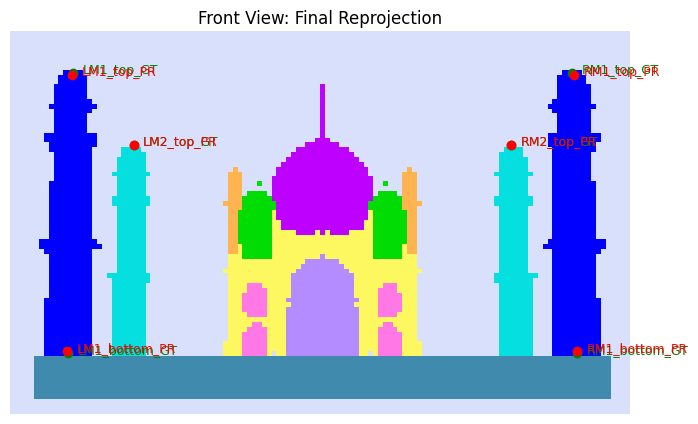


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM1_bottom | (116.5, 66.0)                  | (116.59, 65.56)                | 0.45
RM1_top | (115.5, 8.0)                   | (115.91, 8.42)                 | 0.58
LM1_bottom | (11.5, 66.0)                   | (11.2, 65.56)                  | 0.53
LM1_top | (12.5, 8.0)                    | (12.31, 8.51)                  | 0.55
LM2_top | (25.0, 23.0)                   | (25.01, 22.98)                 | 0.03
RM2_top | (103.0, 23.0)                  | (102.98, 22.97)                | 0.03

Average Reprojection Error: 0.36 pixels
Visualizing combined binary projection vs. binary ground-truth...


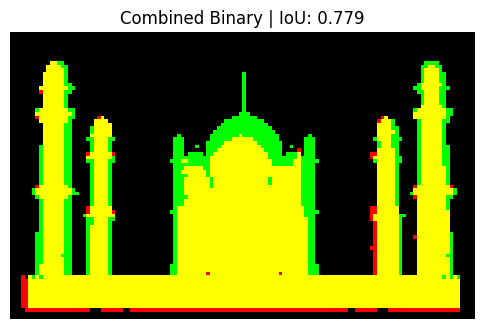


🎯 Optimizing camera for view: drone

📷 Optimized Camera Parameters:
cam_pos: [ -71.05807144   86.6365424  -120.8952127 ]
target: [142.19248214  92.05354137  99.82841023]
f: 566.6476887503482
cx: 317.1777619436151
cy: 0.0
📉 Final Reprojection Loss: 899.41


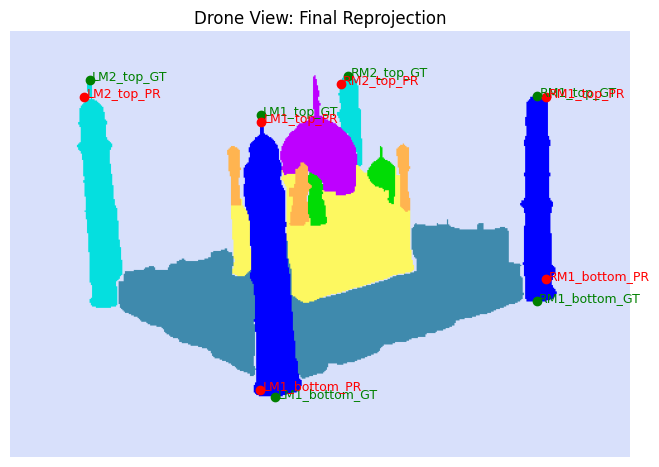


Keypoint | GT (x, y)                      | Projected (x, y)               | Error (L2)
--------------------------------------------------------------------------------
RM1_bottom | (416.5, 213.0)                 | (424.1, 195.43)                | 19.15
RM1_top | (417.0, 51.0)                  | (424.21, 51.74)                | 7.25
LM1_bottom | (209.5, 289.0)                 | (197.31, 283.1)                | 13.54
LM1_top | (198.0, 66.0)                  | (198.61, 71.14)                | 5.17
LM2_top | (62.5, 38.0)                   | (58.39, 51.21)                 | 13.83
RM2_top | (267.5, 35.0)                  | (261.27, 41.32)                | 8.87

Average Reprojection Error: 11.30 pixels
Visualizing combined binary projection vs. binary ground-truth...


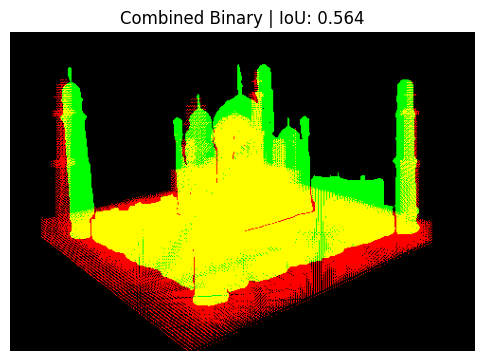

In [4]:
kp_camera_params = {}

for view_name, data in init_keypoints.items():
    print(f"\n🎯 Optimizing camera for view: {view_name}")

    init_params = init_camera_params[view_name]
    voxel_kps_sel = data["voxel"]
    image_kps_sel = data["image"]
    mask_img = data["mask"]

    final_params = optimize_camera_with_keypoints(
        voxel_keypoints_dict=voxel_kps_sel,
        image_keypoints_dict=image_kps_sel,
        image=mask_img,
        init_params=init_params,
        loss_type='L2'
    )

    kp_camera_params[view_name] = final_params

    visualize_reprojection(
        mask_img,
        voxel_kps_sel,
        image_kps_sel,
        final_params,
        title=f"{view_name.capitalize()} View: Final Reprojection"
    )

    visualize_voxel_projection_iou(
        voxel_grid,
        PART_COLORS,
        mask_img,
        final_params,
        mode='whole_on_whole'
    )


### 5. Mask-based optimization

In [5]:
final_camera_params = {}

for view_name in ["front", "drone"]:
    im  = views[view_name]                 # ← FIX
    cam = kp_camera_params[view_name]

    final_camera_params[view_name] = launch_smart_aligner(
        voxel_grid,
        im,
        PART_COLORS,
        parts_for_alignment=["front_minarets", "back_minarets"],
        init_params=cam,
    )


### 6. Save camera parameters

In [7]:
def to_json_safe(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: to_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_json_safe(v) for v in obj]
    return obj

# --- Config ---
project_root = Path.cwd()

out_dir = (
    project_root
    / "results_temp"
    / "2.Perspective_Camera_Estimation"
)
out_dir.mkdir(parents=True, exist_ok=True)

# --- Camera parameter sets ---
camera_sets = {
    "init":  init_camera_params,
    "kp":    kp_camera_params,
    "final": final_camera_params
}

# --- Save ---
for tag, params in camera_sets.items():
    path = out_dir / f"{monument}_camera_params_{tag}.json"
    with open(path, "w") as f:
        json.dump(to_json_safe(params), f, indent=2)
    print(f"Saved: {path.resolve()}")


Saved: /home/sanju/mycode/Part-based-3D-Reconstruction/results_temp/2.Perspective_Camera_Estimation/Bibi_camera_params_init.json
Saved: /home/sanju/mycode/Part-based-3D-Reconstruction/results_temp/2.Perspective_Camera_Estimation/Bibi_camera_params_kp.json
Saved: /home/sanju/mycode/Part-based-3D-Reconstruction/results_temp/2.Perspective_Camera_Estimation/Bibi_camera_params_final.json
